# Tutorial - Green Urban Scenarious
A demo of a minimal flow of GUS process.

For more advanced use cases, please see upcoming article. For more structured experiment and scenario analyis plese see model sepcification and code documentation within docs/ folder. 

In [81]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 3
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json
import pprint
pp = pprint.PrettyPrinter(indent=1)
sns.set_theme()

## 0. Importing GUS modules

In [82]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.gus.models import Urban
from src.gus.utilities import get_raster_data

## 1. Initilisation

### 1.1 Importing data on site, tree populations, experiment parameters

In [83]:
import logging
logfile = os.path.join(module_path, 'outputs/gus.log')
logging.basicConfig(filename=logfile, format='%(asctime)s %(levelname)s %(message)s', level=logging.INFO)

# File that holds site/city other geolocated data and parameters
fname_config_site = os.path.join(module_path, 'inputs/site.json')

# File that include tree species specific parameters
fname_config_allometrics = os.path.join(module_path, 'inputs/allometrics.json')

# File that include individual tree data including their location on a 2D raster of the actual location
fname_data_trees = os.path.join(module_path, 'inputs/trees.csv')

# File that holds experiment parameters
fname_scenario_params = os.path.join(module_path, 'inputs/scenario.json')

In [84]:
f = open(fname_config_allometrics)
config_allometrics = json.loads(f.read())
#pp.pprint(config_allometrics)

In [85]:
f = open(fname_config_site)
config_site = json.loads(f.read())
pp.pprint(config_site)

{'area_impervious_in_m2': 500,
 'area_pervious_in_m2': 500,
 'area_total_in_m2': 1000,
 'area_tree_density_per_hectare': 400,
 'project_site_type': 'park',
 'weather': {'growth_season_mean': 200, 'growth_season_var': 7}}


In [86]:
df_pop = pd.read_csv(fname_data_trees)
df_pop.tail()

,id,species,dbh,height,condition,xpos,ypos
95,96,conifer,13.871098,3.303454,good,17,4
96,97,conifer,12.561324,3.165903,good,17,5
97,98,conifer,13.651542,3.436859,good,17,6
98,99,conifer,12.610441,3.195499,good,17,3
99,100,conifer,12.491068,3.467151,excellent,17,7


In [87]:
f = open(fname_scenario_params)
scenario_params = json.loads(f.read())
pp.pprint(scenario_params)

{'is_crownsunexposure_fixed': 1,
 'maintenance_scope': 1,
 'time_horizon_years': 50}


### 1.2 Creating a digital twin of the site

In [88]:
site = Urban(df_pop,
            fname_config_allometrics,
            fname_config_site,
            scenario_params)

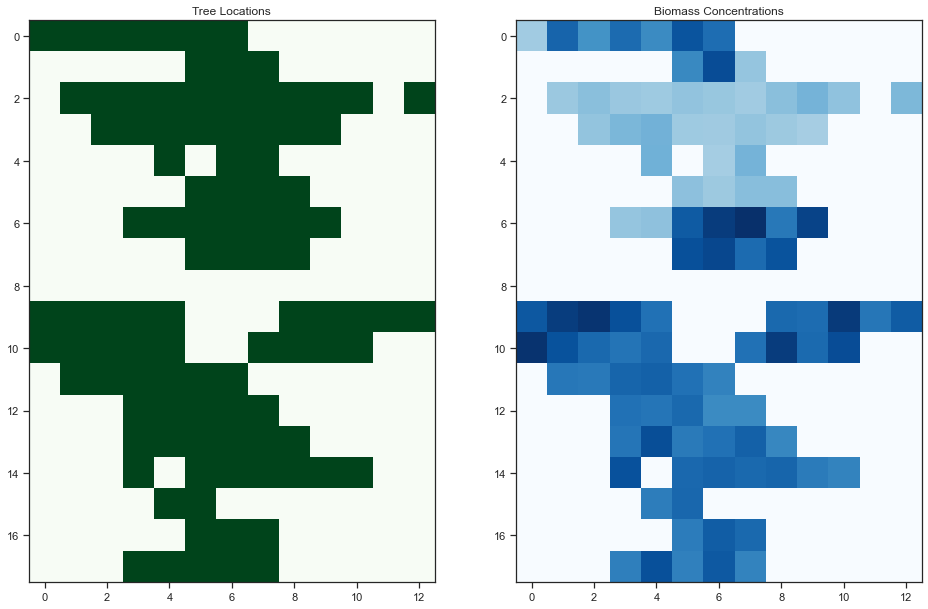

In [89]:
initial_locations = get_raster_data(site, counts=True)
initial_biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,12))
plt.subplot(121)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Tree Locations")
plt.subplot(122)
plt.title("Biomass Concentrations")
plt.imshow(initial_biomass, cmap='Blues')
#plt.colorbar(label = 'Biomass - Kg')
plt.show()

## 2. Running the scenario

In [90]:
for i in range(scenario_params['time_horizon_years']):
    site.step()

## 3. Analysis

### 3.1 Individual tree level inspections 

In [91]:
# Tree level individual variables
fname_output_trees = os.path.join(module_path, 'outputs/trees_yearly.json')
df_out_tree = site.datacollector.get_agent_vars_dataframe()
df_out_tree.to_csv(fname_output_trees, index=True)
df_out_tree.tail()

species       dbh    height    crownH    crownW  canopy_overlap  \
Step AgentID                                                                    
50   319       decidu  9.602855  8.513050  4.369771  3.785064             0.0   
     320       decidu  9.518792  8.472488  4.346529  3.765049             0.0   
     321      conifer  9.150888  5.851132  3.793617  2.358862             0.0   
     322      conifer  9.351192  5.965599  3.847110  2.396624             0.0   
     323      conifer  9.687349  6.156860  3.936513  2.459809             0.0   

               cle  condition   dieback    biomass  seq     carbon  deroot  \
Step AgentID                                                                 
50   319      0.56  excellent  0.005795  38.454037  0.0  19.227019     0.0   
     320      0.56  excellent  0.000387  37.700706  0.0  18.850353     0.0   
     321      0.56  excellent  0.004421  28.248172  0.0  14.124086     0.0   
     322      0.56  excellent  0.000105  29.784608  0.0  14.892304     0.0   
     323      0.56  excellent  0.009119  32.471964  0.0  16.235982     0.0   

              detrunk  mulched  burnt coordinates  
Step AgentID                                       
50   319          0.0      0.0    0.0      (6, 9)  
     320          0.0      0.0    0.0      (5, 7)  
     321          0.0      0.0    0.0     (12, 6)  
     322          0.0      0.0    0.0      (1, 6)  
     323          0.0      0.0    0.0     (11, 5)

In [92]:
Specific_Tree = df_out_tree.xs(42, level="AgentID")
Specific_Tree.tail()

,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,dieback,biomass,seq,carbon,deroot,detrunk,mulched,burnt,coordinates
Step,,,,,,,,,,,,,,,,,
46,decidu,50.742022,21.028150,11.834151,10.823963,0.918013,0.698820,excellent,0.001,1628.462125,11.510107,814.231063,0.0,0.0,0.040712,0.0,"(6, 8)"
47,decidu,51.042819,21.095770,11.859990,10.855171,0.924029,0.696562,excellent,0.002,1650.265105,10.901490,825.132552,0.0,0.0,0.082513,0.0,"(6, 8)"
48,decidu,51.363643,21.167693,11.887089,10.888133,0.925257,0.696565,excellent,0.001,1673.697447,11.716171,836.848723,0.0,0.0,0.041842,0.0,"(6, 8)"
49,decidu,51.658322,21.233574,11.911562,10.918114,0.928286,0.695603,excellent,0.000,1695.382004,10.842278,847.691002,0.0,0.0,0.000000,0.0,"(6, 8)"
50,decidu,51.929218,21.293986,11.933707,10.945426,0.986829,0.682061,excellent,0.001,1715.453328,10.035662,857.726664,0.0,0.0,0.042886,0.0,"(6, 8)"


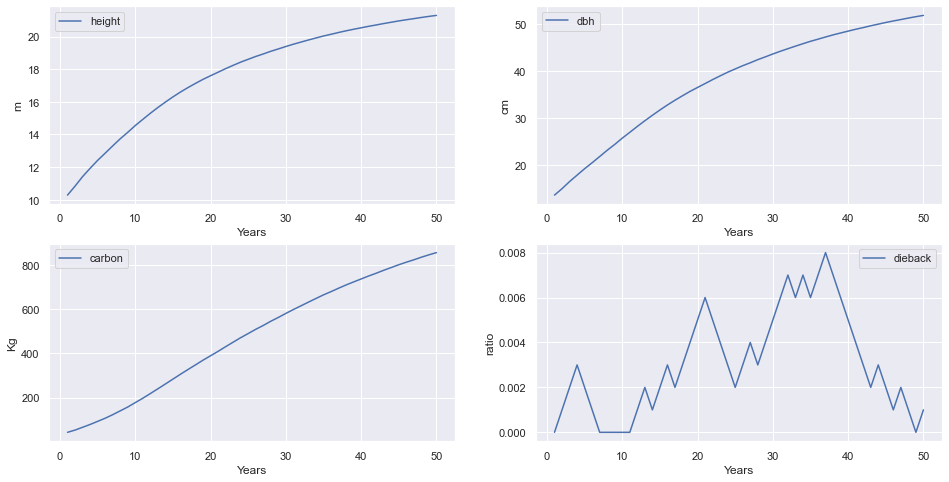

In [93]:
sns.set_theme()
fig = plt.figure(figsize=(16,8))
plt.subplot(221)
Specific_Tree.height.plot()
plt.xlabel('Years')
plt.ylabel('m')
plt.legend()
plt.subplot(222)
Specific_Tree.dbh.plot()
plt.xlabel('Years')
plt.ylabel('cm')
plt.legend()
plt.subplot(223)
Specific_Tree.carbon.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.subplot(224)
Specific_Tree.dieback.plot()
plt.xlabel('Years')
plt.ylabel('ratio')
plt.legend()
plt.show()

### 3.2 Site level inspections

In [94]:
# Site level aggregate variables
df_out_site = site.datacollector.get_model_vars_dataframe()
df_out_site.tail()

,Storage,Seq,Released,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std
45,53754.415729,1038.506619,331.360829,85,15,0,0,0,198,6.495129
46,54730.514123,912.019230,1617.701628,81,19,0,0,0,202,5.893457
47,55746.958033,949.529529,947.015683,77,23,0,0,0,206,6.319567
48,56668.449763,834.734160,1414.973945,72,28,0,0,0,211,5.834773
49,57652.281805,795.559640,899.463175,81,19,0,0,0,223,5.420083


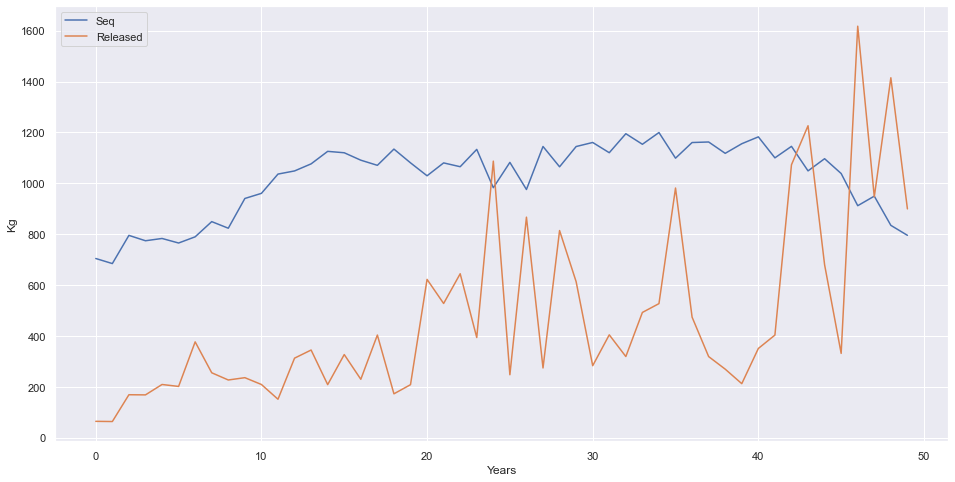

In [95]:
fig = plt.figure(figsize=(16,8))
df_out_site.Seq.plot()
df_out_site.Released.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.show()

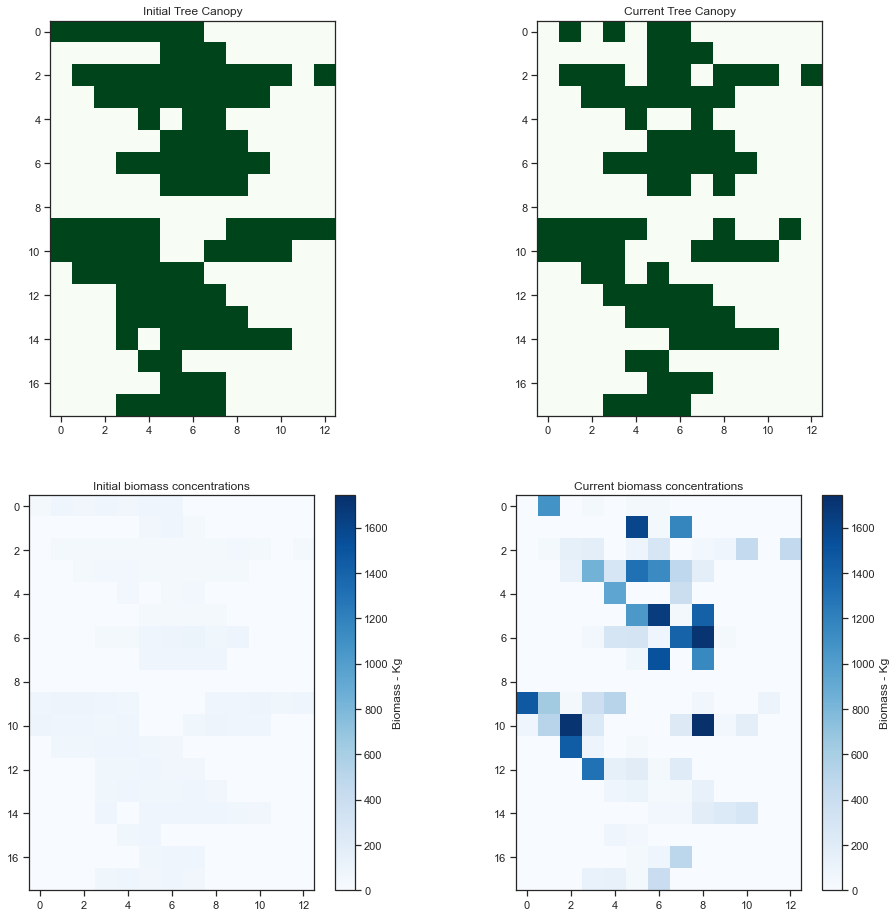

In [96]:
locations = get_raster_data(site, counts=True)
biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Initial Tree Canopy")

plt.subplot(222)
plt.imshow(locations, cmap='Greens')
plt.title("Current Tree Canopy")

plt.subplot(223)
plt.title("Initial biomass concentrations")
plt.imshow(initial_biomass, cmap='Blues', vmin=0, vmax=biomass.max())
plt.colorbar(label = 'Biomass - Kg')

plt.subplot(224)
plt.title("Current biomass concentrations")
plt.imshow(biomass, cmap='Blues')
plt.colorbar(label = 'Biomass - Kg')
plt.show()